<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/4.multilayer_perceptrons/4_6_%1Ddropout_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
def dropout_layer(X, dropout):

  if dropout == 1:
    return tf.zeros_like(X)
  
  if dropout == 0:
    return X
  
  mask = tf.random.uniform(shape=tf.shape(X), minval=0, maxval=1) > dropout
  return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

In [25]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  2.  4.  6.  8.  0. 12. 14.]
 [16.  0. 20.  0. 24.  0.  0.  0.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [26]:
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):

  def __init__(self, num_outputs, num_hiddens1, num_hiddens2):
    super().__init__()
    self.input_layer = tf.keras.layers.Flatten()
    self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
    self.hidden2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
    self.output_layer = tf.keras.layers.Dense(num_outputs)

  def call(self, inputs, training=None):

    x = self.input_layer(inputs)
    x = self.hidden1(x)
    if training:
      x = dropout_layer(x, dropout1)
    x = self.hidden2(x)
    if training:
      x = dropout_layer(x, dropout2)
    x = self.output_layer(x)
    return x

In [27]:
net = Net(num_outputs, num_hiddens1, num_hiddens2)

In [28]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [29]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [30]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [31]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [32]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y))
    return metric[0] / metric[1]

In [33]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    
    x = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

        x.append(epoch)
        train_accs.append(train_metrics[1])
        test_accs.append(test_acc)
        
    plt.plot(x, train_accs, 'r')
    plt.plot(x, test_accs, 'b')
    plt.show()

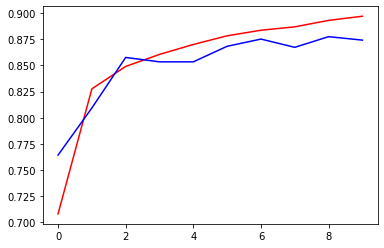

In [34]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)